Предварительно в базу данных cv_project загружены данные:
1. json файлы сописанием, разметкой изображений. Таблицы labels_train, labels_val. Использовался скрипт parse_json_source.py
2. Изображения в виде списков в таблицы images_train, images_test, images_val. Скрипт - parse_img.py
3. boxes, участки изображений вырезанные по разметке. Таблицы boxes_train, boxes_val Скрипт - parse_to_boxes.py
4. boxes, стандартизированные по размеру и преобразованные в feature vectors с помощью HOG алгоритма. Таблицы hog_train, hog_val. Скрипт - parse_to_hog.py

Dockerfile и файлы для сборки контейнера базы данных в папке dockerfiles/ch_dwh/
Файл с ф-ями для работы с бд, файл с примерами  в папке databases/
База clickhouse работает на сервере и доступна авторам проекта и членам комиссии

In [113]:
import os
import sys
sys.path.append(os.path.abspath("databases/"))
import dwh
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
import pickle
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
import cv2

import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

In [111]:
with dwh.def_client(settings={}) as client:
    df_tbl_sizes = client.query_dataframe(
        'select * from system.parts'
    )
print('Table sizes, GB:')
print((df_tbl_sizes.query('database=="cv_project"')
                   .groupby('table')
                   .bytes_on_disk
                   .agg(lambda x: round(sum(x/(1024**3)), 2))
                   .sort_values(ascending=False)))

Table sizes, GB:
table
images_train    139.99
images_test      39.77
boxes_train      26.54
images_val       20.02
hog_train         9.58
boxes_val         3.74
hog_val           1.37
labels_train      0.10
labels_val        0.01
Name: bytes_on_disk, dtype: float64


HOG (Histogram of Oriented Gradients) - гистограмма направленных градиентов. Алгоритм позволяет описать изображение одним вектором. Сначала мы делим изображение на ячейки. Внутри ячейки для каждого пикселя вычисляем разность интенсивности цвета между его  соседями по вертикали и горизонтали, для полученных векторов вычисляем длину суммы и угол между ними. На основании этих значений и строится условная гистограмма для каждой ячейки: bins (ось x) - это дипазон угла между вектороами, а ось y - это длина векторов. Ячейки затем объединяются в блоки, вычисляется общая интенсивность цвета внутри блока и по этому значению нормализуется все гистограммы данного блока.

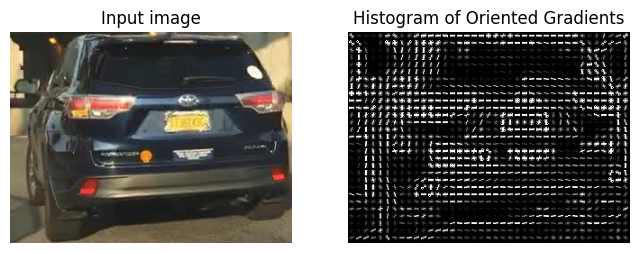

In [141]:
with dwh.def_client(settings={}) as client:
    df_boxes_sample = client.query_dataframe(
        'select * from boxes_train limit 100'
    )
ls_image = df_boxes_sample.query('category == "car"')['ls_box_img'].iloc[0]
image = cv2.cvtColor(np.array(ls_image, dtype=np.uint8), cv2.COLOR_BGR2RGB)
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Для того чтобы hog вектор имел смысл в матрице объект-признак необходимо чтобы изображения имели одинаковое соотношение сторон, чтобы изображения были разбиты на однаковое число блоков и чтобы в блоках было одинаковое количество ячеек. Размер ячейки при этом будет зависеть от размера изображения.

In [ ]:
def calc_hog(ls_img, width, height):
    '''Function we use in hog calculation
    parse_to_hog.py script'''
    if min(width, height) < 32:
        size = 32
    else :
        size = int(32*2**np.floor(np.log2(min(width, height) // 32))) # We standartize image size to 32*2**n. n depends from original image size
    img = cv2.cvtColor(np.array(ls_img, dtype=np.uint8), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))    
    return hog(img, orientations=8, pixels_per_cell=(int(size / 8), int(size / 8)), 
               cells_per_block=(2,2), channel_axis = -1, visualize=False)

Таким образом мы получаем вектора одинаковой длины. 1568 = 49 (число перекрывающихся блоков) * 4 (число ячеек в блоке) * 8 (число "карманов" гистограммы)

In [144]:
with dwh.def_client(settings={}) as client:
    df_hog_sample = client.query_dataframe(
        'select * from hog_train limit 100'
    )

print('All vectors length is 1568')
all([len(i)==1568 for i in df_hog_sample['hog']])

All vectors length is 1568


True

Полученные векторы можно использовать в обучении ML моделей

In [ ]:
# preparing data
# train
with dwh.def_client() as client:
    df_hog_train = client.query_dataframe(
        f"select * from hog_train "
    )

categorical_features = ['weather', 'scene', 'timeofday']
enc = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
enc.fit(df_hog_train[categorical_features])

pickle_obj = {}
pickle_obj['one_hot_enc'] = enc 
cat_fts = enc.transform(df_hog_train[categorical_features])
pickle_obj['features_train'] = np.concatenate((cat_fts.toarray(), np.matrix(df_hog_train['hog'].tolist())), axis=1)
pickle_obj['target_train'] = df_hog_train['category'].tolist()    

# validation
with dwh.def_client() as client:
    df_hog_val = client.query_dataframe(
        f"select * from hog_val "
    )

cat_fts_val = pickle_obj['one_hot_enc'].transform(df_hog_val[categorical_features])
pickle_obj['features_val'] = np.array(np.concatenate((cat_fts_val.toarray(), np.matrix(df_hog_val['hog'].tolist())), axis=1))
pickle_obj['target_val'] = np.array(df_hog_val['category'].tolist())

# pickling
with open('hog_model', 'wb') as file:
    pickle.dump(pickle_obj, file, protocol=pickle.HIGHEST_PROTOCOL)

In [145]:
with open('hog_model', 'rb') as file:
    pickle_obj = pickle.load(file)

In [147]:
print(pickle_obj['features_train'].shape)

(1286871, 1583)


In [ ]:
pickle_obj['lreg'] = LogisticRegression(random_state=42, max_iter=500, warm_start=True)
pickle_obj['lreg'].fit(np.array(pickle_obj['features_train']), np.array(pickle_obj['target_train']))
with open('hog_model', 'wb') as file:
    pickle.dump(pickle_obj, file, protocol=pickle.HIGHEST_PROTOCOL)

In [149]:
pred_val = pickle_obj['lreg'].predict(np.array(pickle_obj['features_val']))
print(f1_score(pickle_obj['target_val'], pred_val, average='micro'))

0.7669059862229552
